In [2]:
#Suja Basnet
#Assignment 03(Image Stitching Implementation)

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Importing two Images

In [16]:
img_ = cv2.imread('first.jpg')
img_ = cv2.resize(img_, (0,0), fx=0.5, fy=0.5)
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY) 
img = cv2.imread('second.jpg')
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# Computing the sift-key points and descriptors for left and right images.

In [17]:
 sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT: kp1 and kp2 are key points,des1 and des2 are the descriptors of the respective images 
kp1,des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

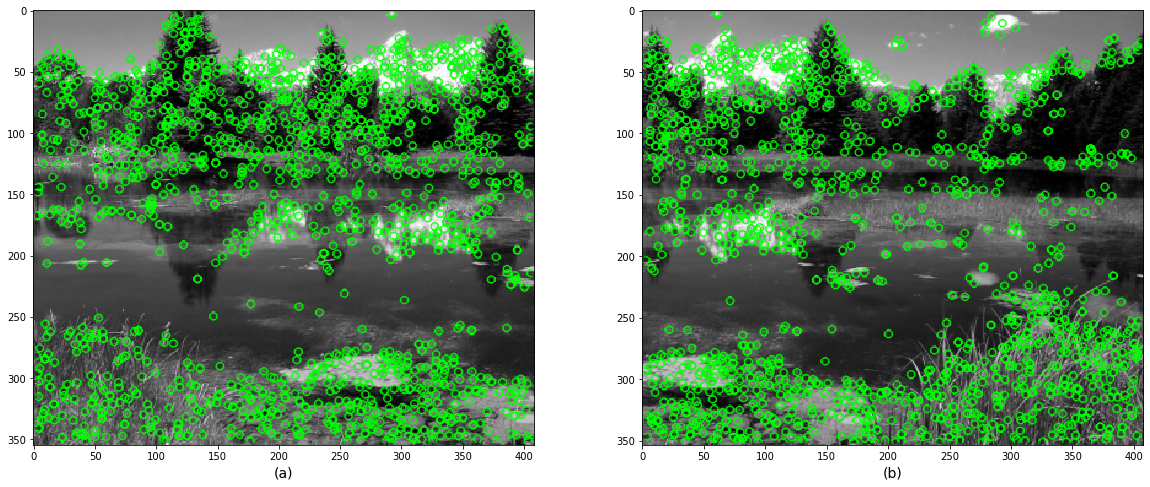

In [18]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img2,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)
plt.show()

# BFMatcher method for matching

In [5]:
 match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)
# “matches” is a list of lists, where each sub-list consists of “k” objects

# Selecting the top best matches for each descriptor of an image.

In [6]:
good = []
for m,n in matches:
    if m.distance < 0.07*n.distance:
        good.append(m)

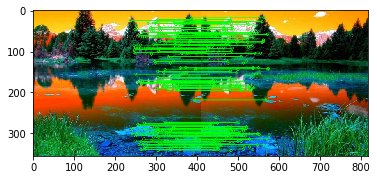

In [7]:
 #Drawing lines on the image. Gives the output to see how it looks like when we found all matches on the image.
draw_params = dict(matchColor =(0,255,0),singlePointColor = None,flags = 2) 
# draw matches in green color 
img3 = cv2.drawMatches(img_,kp1,img,kp2,good,None,**draw_params)
cv2.imwrite("original_image_drawMatches.jpg", img3) 
plt.imshow(img3)

# Estimating Homography

In [8]:
#homography matrix for best matching points
MIN_MATCH_COUNT = 10
##the coding stitching algorithm we need to swap image inputs.
#So “img_” now will take the right image and “IMG” will take the left image. 
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2) 
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) 
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA) 
    #cv2.imshow("original_image_overlapping.jpg", img2)
else:
    print("Not enough matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

# Warp to align for stitching.

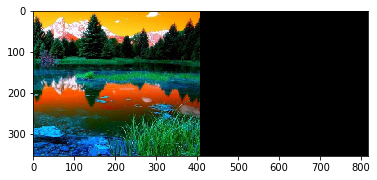

In [9]:
dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0],0:img.shape[1]] = img 
cv2.imwrite("original_image_stitched.jpg", dst)
plt.imshow(dst)
#we are taking overlapping areas from two given images. Then in “DST”, we have received only
#the right side of the image which is not overlapped, so in the second line of code,
#we are placing our left side image to the final image.

# Final Stitched image

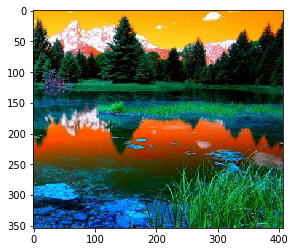

In [10]:
 def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame
cv2.imshow("original_image_stitched_crop.jpg", trim(dst))
plt.imshow(trim(dst))